<h1>Ising Model: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [97]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

In [197]:
#the following functions will help simplify our code throughout or simulstion 
from math import sqrt


def mean(data):
    """ (list) -> (float)
    Returns the mean of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> mean(ex)
    1.5
    """
    return sum(data)/len(data)


def standard_dev(data, ave=None):
    """ (list, float/None) -> float
    Returns the standard deviation of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_dev(ex)
    0.8434622525214579
    """
    if ave is None: #an average is not given and we must calculate it
        ave = mean(data) #finds the average of data
    #otherwise an average is already given as input
    
    #The following code computes the standard deviation of data
    std = 0
    for entry in data:
        std += (entry - ave)**2
        
    return sqrt(std/(len(data)-1))


def variance(data):
    """ (list) -> (float)
    """
    return standard_dev(data)**2

def standard_error(data, std=None):
    """ (list, float/None) -> (float)
    Returns the standard error of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_error(ex)
    0.21778101714468007
    """
    if std is None:
        std = standard_dev(data)
    return std/sqrt(len(data))


def normalised_residuals(x, y, fit, error):
    """ (list, list, function, list) -> (list)
    Finds the residuals of a best fit single-variable function with non-uniform error and
    returns their y-coordiantes. The error array is the standard error of the predicted values
    at each point in x.
    """
    yRes = []
    for i in range(len(x)):
        yRes.append((y[i] - fit(x[i]))/error[i])
    
    return yRes


def durbin_watson(res):
    """ (list) -> (float)
    Returns the Durbin-Watson statistic which uses the residuals to test the fit of a function.
    D=0 : systematically correlated residuals
    D=2 : randomly distributed residuals that follow a Gaussian distribution
    D=4 : systematically anticorrelated residuals
    """
    numerator = 0
    for i in range(1, len(res)):
        numerator += (res[i] - res[i-1])**2
    
    denominator = 0
    for i in range(len(res)):
        denominator += res[i]**2
    
    return numerator/denominator

<h2>1-Dimensional Ising Model</h2>

The one-dimensional Ising model consists of a strip of N sites each containing a spin, $S_i$, pointing in either the positive or negative direction. The energy of a state is defined such that neighboring spins pointing in the same direction as well as spins pointing in the direction of an external field, H, are favored.

$E_{state}=-J\sum_{j=1}^{N}S_jS_{j+1} - H\sum_{j=1}^NS_i$ 

J is strength of interactions between neighboring spins. We will consider the case where the external field H=0. This case reduces the 1D Ising model to a relatively simple system whose thermodynamic quantities can be solved for exactly.

$Z_N=(2*cosh(\frac{J}{k_BT}))^N$

$<E>=-NJ*tanh(\frac{J}{k_BT})$

$<C_V>=NJ^2*sech^2(\frac{J}{k_BT})\frac{1}{k_BT*T}$

$<S_iS_{i+r}>=(tanh(\frac{J}{k_BT}))^r=e^{-r/\xi}, \; \xi=\frac{1}{|ln(tanh(\frac{J}{k_BT}))|}$

Throughout the simulation thermodynamic variables will be defined in units of $J$ and $k_B$. For example, temperature will always be defined in units of $J/k_B$ so $T=m*J/k_B$ for some real number m. This reduces the thermodynamic variables to workable forms.

$Z_N=(2*cosh(\frac{1}{m}))^N$

$<E>=-NJ*tanh(\frac{1}{m})$

$<C_V>=N*sech^2(\frac{J}{k_BT})\frac{k_B}{m}$

$<S_iS_{i+r}>=(tanh(\frac{1}{m}))^r=e^{-r/\xi}, \; \xi=\frac{1}{|ln(tanh(\frac{1}{m}))|}$

The Monte Carlo algorithm we will use consists of creating a strip of positive and negative spins, this will be realized as a 1D numpy array of +1 and -1. We will iterate through each spin and calculate the energy change, $\Delta E$ associated with flipping the spin. The new state will be accepted with probability $Prob=\frac{1}{2}(1-tanh(\frac{\Delta E}{2m}))$, the Glauber rule. We will do this for each spin in the strip, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation. At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can calculate the energy of our simulation. Repeating for diferent temperatures will yield the T dependance of E, thus we can also calculate $C_V$. Finally, the correlation function, $<S_iS_{i+r}>$ can be easily found from our simulation.

<h4>Setup</h4>

In [99]:
def init_grid_1d(length):
    """ (int) -> (np.array)
    Creates an numpy array with 'length' entries of randomly chosen +1 and -1 spins.
    """
    return np.array([random.randrange(-1, 2, 2) for i in range(length)])

def total_mag_1d(grid):
    """ (np.array) -> (int)
    Calculates the total magnetization of a 1-dimensional grid of +1/-1 spins.
    """
    return sum(grid)

def mag_per_spin_1d(grid):
    """ (np.array) -> (float)
    Calculates the magnetization per spin of a 1-dimensional grid of +1/-1 spins.
    """
    return sum(grid)/len(grid)

In [100]:
def energy_change_1d(grid, idx):
    """ (np.array, int) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position. The change is in units of J.
    """
    n = len(grid)
    return 2*grid[idx]*grid[(idx+1)%n] 



from math import tanh
#we will use the Glauber rule to calculate the probability of a state transition
def glauber_1d(grid, idx, temp):
    """ (float, float) -> (float)
    Calculates the probability that a change of state of a 1-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Glauber rule 
    """
    energy = energy_change_1d(grid, idx)
    return 0.5*(1 - tanh(0.5*energy/temp))


def flip_1d(grid, idx, temp):
    """ (np.array, int, float) -> ()
    Flips the spin in grid at site idx with a probability given by the Glauber rule at temperature temp.
    """
    prob = glauber_1d(grid, idx, temp)

    choice = random.choices([0, 1], weights=[1-prob, prob], k=1)[0]
    
    if choice == 1: #will flip
        grid[idx] *= -1
    #otherwise will not flip


def cycle_1d(grid, temp):
    """ (np.array, float) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    length = len(grid) 
    for idx in range(length): #test flip at each site
        flip_1d(grid, idx, temp)


def simulation_1d(grid, temp):
    """ (np.array, float) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    length = len(grid)
    for i in range(length): #N Monte Carlo cycles for N sites is one simulation
        cycle_1d(grid, temp)

<h4>Simulation</h4>

In [218]:
N = 100 #total number of spin sites
num_sim = 10 #total numer of simulations conducted
temperatures = np.linspace(0.1, 2, 19) #range of temperatues at which we will simulate

In [229]:
energies = [] #avergae energies of our simulations at various temperatues
energies_unc = [] #uncertainties in energies

for T in temperatures:
    energy_at_t = []
    for i in range(num_sim): #we do num_sim simulations at each temperature
        strip = init_grid_1d(N)
        simulation_1d(strip, T)
        energy_at_t.append(-total_mag_1d(strip))
    energies.append(mean(energy_at_t))
    energies_unc.append(standard_error(energy_at_t))

Since we have solved the one-dimensional Ising model, $H=0$, exactly we already know what our function for the energy ought to be. We can implement this function and use it to compute the expected values of E at various temperatures, T, and compare with our simulation results.

In [230]:
def expected_energy_1d(temp):
    """ (float, int) -> (float)
    Returns the expected value for the energy/spin (in units of J) at temperature temp (in units of J/k_B) for num_spins spins.
    """
    return -tanh(1/temp)


exp_e = []
for T in temperatures:
    exp_e.append(expected_energy_1d(T))

residuals_1d = normalised_residuals(temperatures, energies, expected_energy_1d, energies_unc)
#the residuals will have the same uncertainty as their respective energy values; the uncertainty in our expected values of E is 0

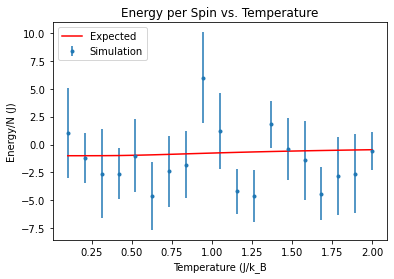

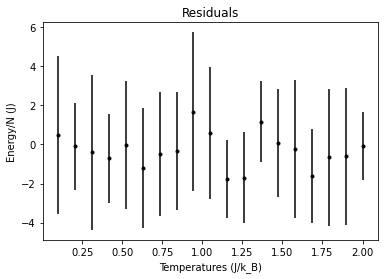

In [231]:
plt.figure()
plt.errorbar(x=temperatures, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation')
plt.plot(temperatures, exp_e, 'r-', label='Expected')
plt.legend(loc='upper left')
plt.title("Energy per Spin vs. Temperature")
plt.ylabel("Energy/N (J)")
plt.xlabel("Temperature (J/k_B")
plt.show()


plt.figure()
plt.errorbar(x=temperatures, y=residuals_1d, yerr=energies_unc, color='k', marker='.', ls='')

plt.title('Residuals')
plt.xlabel('Temperatures (J/k_B)')
plt.ylabel('Energy/N (J)')
plt.show()

In [232]:
durb_1d = durbin_watson(residuals_1d)
print("The Durbin-Watson statistic for results is:", durb_1d)

The Durbin-Watson statistic for results is: 1.5765444957169403
